In [111]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); 
using ForwardDiff
using Test
using RobotZoo
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using BlockArrays
using Printf
using MeshCat
using Plots

include("quadratic_cost.jl")
include("../test/nlp_test.jl")
include("cartpole.jl")

 Activating environment at `~/Classes/OptimalControl/hw3_solutions/Project.toml`


get_control (generic function with 2 methods)

# Q1: Sequential Quadratic Programming (SQP) (50 pts)
In this problem you'll solve the canonical cartpole swing-up problem using sequential-quadratic programming (SQP), as we learned in class. While coding up a complete SQP solver is very challenging, we'll simplify it by only considering problems of the form:

$$\begin{aligned} &\text{minimize}_z && \frac{1}{2} z^T Q z + q^T z \\
&\text{subject to} && c(z) = 0 \end{aligned} $$

I.e. we'll only have you worry about equality constraints. Your overall algorithm should run something like this:
1. Initialization
2. Build the QP for the current step by taking Taylor series approximations of the cost and constraints
3. Solve the QP to get search directions for you primal and dual variables
4. Use a line search (or other globalization strategy) to find a good step
5. If termination conditions are satisfied, exit; otherwise, go to 2

## The Problem
You likely have already seen the cartpole swing-up problem previously. As shown in the picture below, the system is comprised of a pendulum attached to a cart, where forces can only be applied to the cart. The goal is to balance the pendulum above the cart. The system dynamics can be written as:

$$ x = \begin{bmatrix} y \\ \theta \\ v \\ \omega \end{bmatrix}, \quad \dot{x} = \begin{bmatrix} \dot{q} \\ \ddot{q} \end{bmatrix}, \quad
q = \begin{bmatrix} y \\ \theta \end{bmatrix}, \quad
\ddot{q} = -H^{-1} (C \dot{q} + G - B u)$$

where 
$$ H = \begin{bmatrix} m_c + m_p & m_p l \cos{\theta} \\
m_p l \cos{\theta} & m_p l^2 \end{bmatrix}, \;
C = \begin{bmatrix} 0 & -m_p \omega l \sin{\theta} \\ 0 & 0 \end{bmatrix}, \;
G = \begin{bmatrix} 0 \\ m_p g l \sin{\theta} \end{bmatrix}, \;
B = \begin{bmatrix} 1 \\ 0 \end{bmatrix} $$

with the following parameters:
* $m_p$: mass of the pole
* $m_c$: mass of the cart
* $g$: gravity
* $l$: length of the rod

In [2]:
# Build the problem
model = RobotZoo.Cartpole()
n,m = size(model)
T = 101
tf = 2.0
dt = tf / (T-1)

# Initial & final condition
x0 = @SVector zeros(n)
xf = SA[0,pi,0,0];

# Cost function
Q = Diagonal(fill(1e-2,n))
R = Diagonal(fill(1e-1,m))
Qf = Diagonal(fill(1e1,n))
costfun = LQRCost(Q,R,xf)
costterm = LQRCost(Qf,R,xf)
obj = push!(fill(costfun,T-1), costterm)

# Initial Guess (linear interpolation)
X = [x0 + (xf - x0)*t for t in range(0,1, length=T)]
U = [@SVector zeros(m) for k = 1:T-1];

## Part (a): Evaluate the NLP
Before we put together our SQP method, let's write some convenient methods for evaluating the information we'll need from the NLP. We've given you a struct `NLP` below that contains all the information you'll need to evaluate things like the cost function, constraints, and their derivatives.

In [3]:
"""
    NLP{n,m,L,Q}

Represents a (N)on(L)inear (P)rogram of a trajectory optimization problem,
with a dynamics model of type `L`, a quadratic cost function, horizon `T`, 
and initial and final state `x0`, `xf`.

The kth state and control can be extracted from the concatenated state vector `Z` using
`Z[nlp.xinds[k]]`, and `Z[nlp.uinds[k]]`.

# Constructor
    NLP(model, obj, tf, T, x0, xf, [integration])

# Basic Methods
    Base.size(nlp)    # returns (n,m,T)
    num_ineq(nlp)     # number of inequality constraints
    num_eq(nlp)       # number of equality constraints
    num_primals(nlp)  # number of primal variables
    num_duals(nlp)    # total number of dual variables
    packZ(nlp, X, U)  # Stacks state `X` and controls `U` into one vector `Z`

# Evaluating the NLP
The NLP supports the following API for evaluating various pieces of the NLP:

    eval_f(nlp, Z)         # evaluate the objective
    grad_f!(nlp, grad, Z)  # gradient of the objective
    hess_f!(nlp, hess, Z)  # Hessian of the objective
    eval_c!(nlp, c, Z)     # evaluate the constraints
    jac_c!(nlp, c, Z)      # constraint Jacobian
"""
struct NLP{n,m,L,Q}
    model::L                                 # dynamics model
    obj::Vector{QuadraticCost{n,m,Float64}}  # objective function
    T::Int                                   # number of knot points
    tf::Float64                              # total time (sec)
    x0::MVector{n,Float64}                   # initial condition
    xf::MVector{n,Float64}                   # final condition
    xinds::Vector{SVector{n,Int}}            # Z[xinds[k]] gives states for time step k
    uinds::Vector{SVector{m,Int}}            # Z[uinds[k]] gives controls for time step k
    times::Vector{Float64}                   # vector of times
    function NLP(model::AbstractModel, obj::Vector{<:QuadraticCost{n,m}},
            tf::Real, T::Integer, x0::AbstractVector, xf::AbstractVector, integration::Type{<:QuadratureRule}=RK4
        ) where {n,m}
        xinds = [SVector{n}((k-1)*(n+m) .+ (1:n)) for k = 1:T]
        uinds = [SVector{m}((k-1)*(n+m) .+ (n+1:n+m)) for k = 1:T-1]
        times = collect(range(0, tf, length=T))
        new{n,m,typeof(model), integration}(
            model, obj,
            T, tf, x0, xf, xinds, uinds, times
        )
    end
end
Base.size(nlp::NLP{n,m}) where {n,m} = (n,m,nlp.T)
num_primals(nlp::NLP{n,m}) where {n,m} = n*nlp.T + m*(nlp.T-1)
num_duals(nlp::NLP) = num_eq(nlp) + num_ineq(nlp)
num_eq(nlp::NLP{n,m}) where {n,m} = n*nlp.T + n
num_ineq(nlp::NLP) = 0

"""
    packZ(nlp, X, U)

Take a vector state vectors `X` and controls `U` and stack them into a single vector Z.
"""
function packZ(nlp, X, U)
    Z = zeros(num_primals(nlp))
    for k = 1:nlp.T-1
        Z[nlp.xinds[k]] = X[k]
        Z[nlp.uinds[k]] = U[k]
    end
    Z[nlp.xinds[end]] = X[end]
    return Z
end

"""
    unpackZ(nlp, Z)

Take a vector of all the states and controls and return a vector of state vectors `X` and
controls `U`.
"""
function unpackZ(nlp, Z)
    X = [Z[xi] for xi in nlp.xinds]
    U = [Z[ui] for ui in nlp.uinds]
    return X, U
end

unpackZ

### Objective
Complete the following methods to evaluate the objective and its derivatives.

In [4]:
# TASK: Finish the following methods
#       eval_f
#       grad_f!
#       hess_f!

"""
    eval_f(nlp, Z)

Evaluate the objective, returning a scalar.
"""
function eval_f(nlp::NLP, Z)
    # TASK: compute the objective value (cost)
    J = 0.0
    
    # SOLUTION
    xi,ui = nlp.xinds, nlp.uinds
    for k = 1:nlp.T-1
        x,u = Z[xi[k]], Z[ui[k]]
        J += stagecost(nlp.obj[k], x, u)
    end
    J += termcost(nlp.obj[end], Z[xi[end]])
    return J
end

"""
    grad_f!(nlp, grad, Z)

Evaluate the gradient of the objective at `Z`, storing the result in `grad`.
"""
function grad_f!(nlp::NLP{n,m}, grad, Z) where {n,m}
    xi,ui = nlp.xinds, nlp.uinds
    obj = nlp.obj
    for k = 1:nlp.T-1
        x,u = Z[xi[k]], Z[ui[k]]
        # TASK: Compute the cost gradient
        grad[xi[k]] .= 0
        grad[ui[k]] .= 0
        
        # SOLUTION
        grad[xi[k]] = obj[k].Q*x + obj[k].q
        grad[ui[k]] = obj[k].R*u + obj[k].r
    end
    grad[xi[end]] = obj[end].Q*Z[xi[end]] + obj[end].q
    return nothing
end

"""
    hess_f!(nlp, hess, Z)

Evaluate the Hessian of the objective at `Z`, storing the result in `hess`.
Should work with `hess` sparse.
"""
function hess_f!(nlp::NLP{n,m}, hess, Z, rezero=true) where {n,m}
    # TASK: Compute the objective hessian
    # HINT: It's a diagonal matrix
    if rezero
        for i = 1:size(hess,1)
            hess[i,i] = 0
        end
    end
    xi,ui = nlp.xinds, nlp.uinds
    obj = nlp.obj
    i = 1
    for k = 1:nlp.T
        for j = 1:n
            hess[i,i] += nlp.obj[k].Q[j,j]
            i += 1
        end
        if k < nlp.T
            for j = 1:m
                hess[i,i] += nlp.obj[k].R[j,j]
                i += 1
            end
        end
    end
end

hess_f!

## Constraints
Complete the following methods to evaluate the constraints and their derivatives.

In [5]:
# TASK: Complete the following methods
#       eval_c!
#       jac_c!
#       ∇jvp!
"""
    eval_c!(nlp, c, Z)

Evaluate the equality constraints at `Z`, storing the result in `c`.
The constraints should be ordered as follows: 
1. Initial condition ``x_1 = x_\\text{init}``
2. Dynamics ``f(x_k,u_k) - x_{k+1} = 0``
3. Terminal constraint ``x_T = x_\\text{goal}``
"""
function eval_c!(nlp::NLP{n,m,<:Any,Q}, c, Z) where {n,m,Q}
    T = nlp.T
    xi,ui = nlp.xinds, nlp.uinds
    idx = xi[1]

    # TODO: initial condition
    c[idx] = Z[xi[1]] - nlp.x0

    # dynamics
    for k = 1:T-1
        idx = idx .+ n
        x,u = Z[xi[k]], Z[ui[k]]
        x⁺ = Z[xi[k+1]]
        dt = nlp.times[k+1] - nlp.times[k]
        
        # TASK: Dynamics constraint
        c[idx] .= 0
        
        # SOLUTION
        c[idx] = discrete_dynamics(Q, nlp.model, x, u, nlp.times[k], dt) - x⁺
    end

    # TODO: terminal constraint
    idx = idx .+ n
    c[idx] .= 0
    
    # SOLUTION
    c[idx] = Z[xi[T]] - nlp.xf
    return nothing
end

"""
    jac_c!(nlp, jac, Z)

Evaluate the constraint Jacobian, storing the result in the (potentially sparse) matrix `jac`.
"""
function jac_c!(nlp::NLP{n,m,<:Any,Q}, jac, Z) where {n,m,Q}
    # TODO: Initial condition
    # SOLUTION
    for i = 1:n
        jac[i,i] = 1
    end

    xi,ui = nlp.xinds, nlp.uinds
    idx = xi[1]
    for k = 1:nlp.T-1
        idx = idx .+ n 
        zi = [xi[k];ui[k]]
        zi2 = k < T-1 ? zi .+ (n+m) : xi[T]
        x = Z[xi[k]]
        u = Z[ui[k]]
        t = nlp.times[k]
        dt = nlp.times[k+1] - nlp.times[k]

        ∇f = view(jac, idx, zi)
        ∇f2 = view(jac, idx, zi2)
        
        # TODO: Dynamics constraint
#         z = StaticKnotPoint(Z[zi], xi[1], ui[1], dt, nlp.times[k])
#         discrete_jacobian!(Q, ∇f, nlp.model, z, nothing)
        discrete_jacobian!(Q, ∇f, nlp.model, x, u, t, dt)
        for i = 1:n
            ∇f2[i,i] = -1
#             jac[idx[i], zi[end]+i] = -1
        end
    end
    idx = idx .+ n 
    
    # TODO: Terminal constraint
    # SOLUTION
    for i = 1:n
        jac[idx[i], xi[end][i]] = 1
    end
end

jac_c!

## Lagrangian

In [6]:
# TASK: Complete the following methods
#       lagrangian
#       grad_lagrangian!
#       hess_lagrangian!

"""
    lagrangian(nlp, Z, λ, c)

Evaluate the Lagrangian at `Z` and `λ`. Calculates the constraints, storing the result in `c`.

The sign on the multipliers should be negative, e.g. J(x) - λ'c(x)
"""
function lagrangian(nlp::NLP{n,m}, Z, λ, c=zeros(eltype(Z),length(λ))) where {n,m}
    # TODO: Calculate the Lagrangian
    L = 0
    
    J = eval_f(nlp, Z)
    eval_c!(nlp, c, Z)
    L = J - dot(λ,c)
    return L
end

"""
    grad_lagrangian(nlp, grad, Z, λ)

Evaluate the gradient of the Lagrangian.
"""
function grad_lagrangian!(nlp::NLP{n,m}, grad, Z, λ, jac = spzeros(length(λ), length(Z))) where {n,m}
    # TODO: Calculate the gradient of the Lagrangian, store the result in grad
    
    # SOLUTION
    jac_c!(nlp, jac, Z)
    grad_f!(nlp, grad, Z)
    grad .-= jac'λ
    return nothing
end

grad_lagrangian!

## Residuals
Feel free to use these function to evaluate the primal and dual residuals.

In [7]:
"""
    primal_residual(nlp, Z, λ, [g; p])

Evaluate the `p`-norm of the primal residual (stationarity condition).
"""
function primal_residual(nlp::NLP, Z, λ, g=zeros(num_primals(nlp)); p=2)
    grad_lagrangian!(nlp, g, Z, λ)
    return norm(g, p)
end

"""
    dual_residual(nlp, Z, λ, [c; p])

Evaluate the `p`-norm of the dual residual (constraint violation).
"""
function dual_residual(nlp::NLP, Z, λ, c=zeros(num_eq(nlp)); p=2)
    eval_c!(nlp, c, Z)
    norm(c, p)
end

dual_residual

### Testing the Methods

In [9]:
nlp = NLP(model, obj, tf, T, x0, xf)
Z = packZ(nlp, X, U)
λ = zeros(num_duals(nlp));

In [12]:
include("../test/nlp_test.jl")

test_nlp (generic function with 1 method)

In [14]:
# Test methods
test_nlp(nlp, Z, λ);

Test Summary: | Pass  Total
NLP tests     |  115    115


## Part (b): Solving the QP
Now that we have methods to evaluate our NLP and its derivatives, we need some methods to form the QP from our NLP and then solve it. Use the struct we've provided below and implement the `build_qp!` method to update the QP sub-problem from the current primal and dual variables, as well as the `solve_qp!` method to solve it for the step directions in the primal and dual variables. Note that since our NLP only has equality constraints, the QP sub-problem will also only have equality constraints, so it can be solved directly using a linear solve on the KKT conditions.

In [15]:
@doc raw"""
    TOQP

A type specifying a (T)rajectory (O)ptimization (Q)uadratic (P)rogram, of the form


``\begin{aligned} &\text{minimize} &&\frac{1}{2} z^T Q z + q^T z \\ 
&\text{subject to} && A z = b \\ 
&&& l \leq C z \leq u \end{aligned}``

where ``z = [x_1^T \; u_1^T \; \dots \; x_{T-1}^T \; u_{T-1}^T \; x_T^T]^T`` and 
``x \in \mathbb{R}^n`` is the state vector and ``u \in \mathbb{R}^m`` is the control vector.

# Constructors

    TOQP(n,m,T,M,P)

where `n` is the number of states, `m` is the number of controls, `T` is the horizon, `M` is the number of equality 
constraints, and `P` is the number of inequality constraints.

# Methods

    num_ineq(qp)     # number of inequality constraints
    num_eq(qp)       # number of equality constraints
    num_primals(qp)  # number of primal variables
    num_duals(qp)    # total number of dual variables


"""
struct TOQP
    Q::SparseMatrixCSC{Float64,Int}  # quadratic cost
    q::Vector{Float64}               # linear cost
    A::SparseMatrixCSC{Float64,Int}  # equality constraint Ax = b
    b::Vector{Float64}               # equality constraint 
    C::SparseMatrixCSC{Float64,Int}  # inequality constraint l ≤ Cx ≤ u
    l::Vector{Float64}               # inequality constraint lower bound
    u::Vector{Float64}               # inequality constraint upper bound
    n::Int
    m::Int
    T::Int

    function TOQP(n,m,T,M,P)
        N = n*T + (T-1)*m
        Q = spzeros(N,N)
        q = zeros(N)
        A = spzeros(M,N)
        b = zeros(M) 
        C = spzeros(P,N)
        l = fill(-Inf,P)
        u = fill(Inf,P)

        new(Q,q,A,b,C,l,u,n,m,T)
    end
end


function TOQP(nlp::NLP{n,m}) where {n,m}
    TOQP(n,m,nlp.T, num_eq(nlp), num_ineq(nlp))
end

num_ineq(qp::TOQP) = length(qp.l)
num_eq(qp::TOQP) = length(qp.b)
num_primals(qp::TOQP) = length(qp.q)
num_duals(qp::TOQP) = num_ineq(qp) + num_eq(qp)

num_duals (generic function with 2 methods)

### Build the QP

In [16]:
# TASK: Complete the following method to build the QP sub-problem
"""
    build_qp!(qp, nlp, Z, λ; [gn=true])

Build a QP from the NLP, evaluated at primal variables `Z` and dual variables `λ`, 
optionally using either the Hessian of the cost function (`gn = true`) or the Hessian of the Lagrangian (`gn = false`).
"""
function build_qp!(qp::TOQP, nlp::NLP, Z, λ; gn::Bool=true)
    # TODO: Build the qp, filling in qp.Q, qp.q, qp.A, qp.b
    jac_c!(nlp, qp.A, Z)
    eval_c!(nlp, qp.b, Z)
    qp.b .*= -1  # reverse sign
    grad_lagrangian!(nlp, qp.q, Z, λ)

    if gn
        hess_f!(nlp, qp.Q, Z)
    else
        hess_lagrangian!(nlp, qp.Q, Z, λ)
    end
    return nothing
end

build_qp!

### Solve the QP

In [17]:
# TASK: Complete the function to solve the QP
"""
    solve_qp!(qp, [reg])

Solve the QP, optionally applying regularization `reg`.
"""
function solve_qp!(qp::TOQP, reg=0.0)
    # TODO: Solve the QP sub-problem
    # HINT: Form the KKT system and solve with a single linear solve
    N,M = num_primals(qp), num_duals(qp)
    
    # SOLUTION
    K = [qp.Q + reg*I qp.A'; qp.A -reg*I]
    t = [-qp.q; qp.b]
    dY = K\t
    dZ = dY[1:N]
    dλ = dY[N+1:N+M]
    return dZ, dλ
end

solve_qp!

## Part (c): Writing the SQP Method
Now that you have all the pieces, put them all together into an SQP method. You'll need to implement some sort of globalization strategy to make sure you take good steps. A line search with a merit function will work well, but feel free to try other methods.

In [25]:
# TASK: Complete the SQP method
"""
    solve_sqp!(nlp, Z, λ; kwargs...)

Solve the trajectory optimization problem specified by `nlp` using Sequential Quadratic Programming, given the initial 
guess for the primal variables `Z` and `λ`.
"""
function solve_sqp!(nlp, Z0, λ0;
        iters=100,                   # max number of iterations
        verbose=0,                   # verbosity level
        eps_primal=1e-6,             # primal feasibility tolerance
        eps_dual=1e-4,               # dual feasibility tolerance
        eps_fn=sqrt(eps_primal),     # 
        gn::Bool=true,               # use Gauss-Newton approximation
        enable_soc::Bool=true,       # enable Second-Order-Corrections during the line search
        ls_iters=10,                 # max number of line search iterations
        reg_min=1e-6,                # minimum regularization
    )
    t_start = time_ns()

    # Initialize solution
    Z = deepcopy(Z0)
    λ = deepcopy(λ0)
    qp = TOQP(size(nlp)..., num_eq(nlp), 0)

    # Line Search parameters
    μ = 10.0
    ḡ = zero(Z)
    c̄ = zero(λ)
    Z̄ = zero(Z)
    dZ = zero(Z)
    reg = reg_min 
    
    stats = Dict(
        :cost => Float64[],
        :viol_primal => Float64[],  # constraint violation
        :viol_dual => Float64[],    # stationarity
        :time => Float64[]
    )

    for iter = 1:iters
        ## Check the residuals and cost
        res_p = primal_residual(nlp, Z, λ)
        res_d = dual_residual(nlp, Z, λ)
        J = eval_f(nlp, Z)
        push!(stats[:viol_primal], res_d)
        push!(stats[:viol_dual], res_p)
        verbose > 0 && @printf("Iteration %d: cost = %0.2f, res_p = %0.2e, res_d = %0.2e,", iter, J, res_p, res_d)

        # Termination conditions
        if res_p < eps_dual && res_d < eps_primal
            verbose > 0 && println()
            break
        end

        # Build QP
        build_qp!(qp, nlp, Z, λ, gn=gn)
        
        # Solve the QP
        dZ, dλ = solve_qp!(qp, reg)

        # Update penalty paramter
        μ_min = minimum_penalty(qp.Q, qp.q, qp.b, dZ)
        if μ < μ_min
            μ = μ_min*1.1
        end

        # Line Search
        α = 1.0
        J0 = eval_f(nlp, Z)
        grad0 = qp.q
        c0 = qp.b
        phi0 = J0 + μ * norm(c0, 1)            # merit function
        dphi0 = grad0'dZ - μ * norm(c0, 1)     # gradient of the merit function (Nocedal & Wright Theorem 18.2)
        phi = Inf
        
        push!(stats[:cost], J0)

        soc = false
        τ = 0.5
        η = 1e-2
        # verbose > 2 && @printf("\n   ϕ0: %0.2f, ϕ′: %0.2e, %0.2e\n", phi0, dphi0, dphi1)
        for i = 1:10
            # Calculate merit function at new step
            Z̄ .= Z .+ α .* dZ
            eval_c!(nlp, c̄, Z̄)
            phi = eval_f(nlp, Z̄) + μ * norm(c̄, 1)

            # Check Armijo
            if phi < phi0 + η*α*dphi0
                reg = max(reg /= 100, reg_min)
                break
            # Try second-order correction
            elseif α == 1.0 && enable_soc
                A = qp.A
                psoc = -A'*((A*A')\(c̄))
                Z̄ .= Z .+ dZ .+ psoc
                eval_c!(nlp, c̄, Z̄)
                phi = eval_f(nlp, Z̄) + μ * norm(c̄, 1)
                if phi < phi0 + η*α*dphi0
                    soc = true
                    reg = max(reg /= 100, reg_min)
                    break
                else
                    α *= τ
                end
            else
                α *= τ
            end

            # Line search failure
            if i == 10
                reg *= 10    # increase regularization
                α = 0        # don't take a step
                Z̄ .= Z 
                @warn "line search failed"
            end
        end
        # Apply step
        Z .= Z̄
        λ .= λ .- α .* dλ

        # Output
        verbose > 0 && @printf("   α = %0.2f, ΔJ: %0.2e, Δϕ: %0.2e, reg: %0.2e, pen: %d, soc: %d\n", 
            α, J - eval_f(nlp, Z), phi0 - phi, reg, μ, soc)
        push!(stats[:time], (time_ns() - t_start) / 1e6)  # ms
    end
    push!(stats[:time], (time_ns() - t_start) / 1e6)  # ms
    push!(stats[:cost], eval_f(nlp, Z))
    return Z, λ, stats 
end

"""
    minimum_penalty(Q,q,c, dZ; ρ)

Calculate the minimum penalty needed for the exact penalty function, where `Q` is the Hessian, `q` is the gradient, 
`c` is the constraint violation, and `dZ` is the search direction. (See Nocedal & Wright Eq. 18.36)
"""
function minimum_penalty(Q,q,c, dZ; ρ=0.5)
    a = dot(dZ, Q, dZ)
    σ = a > 0
    num = q'dZ + σ*0.5*a
    den = (1-ρ) * norm(c)
    return num/den
end

minimum_penalty

In [26]:
# TASK: Solve the problem with SQP
#       Save the output to Zgn, λgn, stats_gn
#       Solve to a tolerance of 1e-6 for constraint satisfaction and 1e-4 for stationarity condition

Z = packZ(nlp, X, U)
λ = zeros(num_duals(nlp))
Zgn, λgn, stats_gn = solve_sqp!(nlp, Z, λ, verbose=0, gn=true);
length(stats_gn[:time])

79

## Visualization

In [22]:
vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat /home/brian/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))),"box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8702))

In [28]:
Xgn = [Zgn[xi] for xi in nlp.xinds]
visualize!(vis, model, tf, Xgn)

## Part (d): Implement Full Newton
To compute the full Newton step, we need to evaluate the second-order derivatives of our constraints. Complete the methods below to calculate the full 2nd-order expansion of the Lagrangian.

In [29]:
# TASK: Finish the methods below
#       ∇jvp!
#       hess_lagrangian!

"""
    ∇jvp!(nlp, hess, Z, λ)

Evaluate the Jacobian of the constraint Jacobian-transpose vector product, e.g. ``\\frac{\\partial}{\\partial z} \\nabla c^T \\lambda``,
storing the result in the (potentially sparse) matrix `hess`.
"""
function ∇jvp!(nlp::NLP{n,m,<:Any,Q}, hess, Z, λ) where {n,m,Q}
    xi,ui = nlp.xinds, nlp.uinds
    idx = [xi[1]; ui[1]]
    idx2 = xi[1]
    
    # TODO: Initial Constraint
    
    # Dynamics constraints
    for k = 1:nlp.T-1
        idx2 = idx2 .+ n
        zi2 = k < T-1 ? idx .+ (n+m) : xi[T]
        x = Z[xi[k]]
        u = Z[ui[k]]
        λk = λ[idx2]
        t = nlp.times[k]
        dt = nlp.times[k+1] - nlp.times[k]
        
        ∇f = view(hess, idx, idx)
        ∇f2 = view(hess, idx, zi2)
        
        # TODO: Calculate second derivative the dynamics
        # SOLUTION
#         zi = [xi[k];ui[k]]
#         z = StaticKnotPoint(Z[zi], xi[1], ui[1], dt, nlp.times[k])
#         RobotDynamics.∇discrete_jacobian!(Q, ∇f, nlp.model, z, λk)
        ∇discrete_jacobian!(Q, ∇f, nlp.model, x, u, t, dt, λk)
        
        # Advance indices
        idx = idx .+ (n + m)
    end
    # TODO: Terminal constraint
#     for i = 1:n
#         hess[end-i+1,end-i+1] = 0
#     end
end

"""
    hess_lagrangian(nlp, grad, Z, λ)

Evaluate the Hessian of the Lagrangian.
"""
function hess_lagrangian!(nlp::NLP{n,m}, hess, Z, λ) where {n,m}
    # TODO: Calculate the Hessian of the Lagrangian, store the result in hess
    
    # SOLUTION
    ∇jvp!(nlp, hess, Z, λ)
    hess .*= -1
    hess_f!(nlp, hess, Z, false)
    return nothing
end


hess_lagrangian!

In [30]:
# Test the methods
test_nlp(nlp, Z, λ, full_newton=true);

Test Summary: | Pass  Total
NLP tests     |  116    116


## Part (e): Solve with Full Newton
Now that we can calculate our full Newton step, modify `build_qp!` to use `hess_lagrangian!` when the `gn` is false. Then solve the problem with the full Newton solve.

In [34]:
# TASK: Do the following
#       1. Modify build_qp! to use the full Newton Hessian when `gn = false`
#       2. Solve the problem using full Newton steps. Save the result in Zfn, λfn, stats_fn

# SOLUTION
Z = packZ(nlp, X, U)
λ = zeros(num_duals(nlp))
Zfn, λfn, stats_fn = solve_sqp!(nlp, Z, λ, verbose=0, gn=false, eps_dual=1e-4);
length(stats_fn[:time])

11

## Part (f): Convergence Comparison
Let's compare the convergence of Gauss Newton versus Full Newton. Generate the following plots:
1. Constraint violation vs iterations. Include a line for both Gauss and Full Newton
2. Constraint violation vs time. Include a line for both Gauss and Full Newton

Once you've generated the plots, take a minute to think about they tell you. What are the tradeoffs of using Gauss-Newton vs full Newton?

You are free to use whatever plotting library you want (we suggest PyPlot.jl or Plots.jl).

**TIP**: Save the data you need in the stats dictionary that returned from the sqp solver.

**TIP**: If your plot vs time has a large offset before the first iteration, run your solver again (remember it has to compile the first time through).

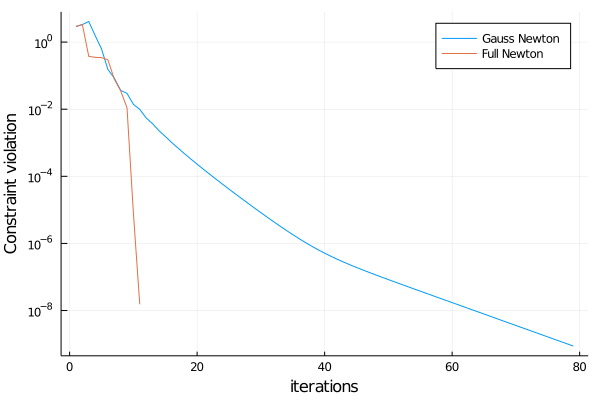

In [35]:
# TASK: Plot constraint violation vs iterations
plot(stats_gn[:viol_primal], label="Gauss Newton",
    yscale=:log10, xlabel="iterations", ylabel="Constraint violation", legend=:topright
)
plot!(stats_fn[:viol_primal], label="Full Newton")

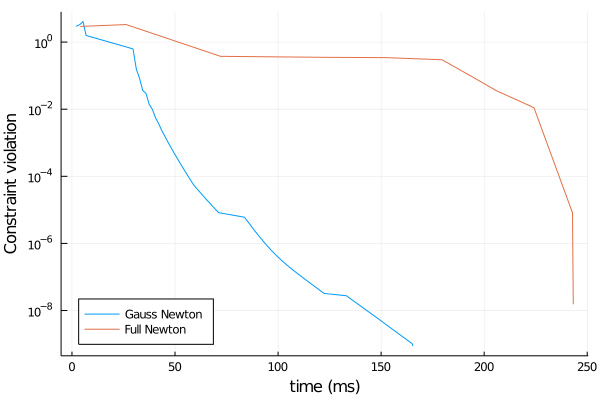

In [36]:
# TASK: Plot constraint violation vs time
plot(stats_gn[:time], stats_gn[:viol_primal], label="Gauss Newton",
    yscale=:log10, xlabel="time (ms)", ylabel="Constraint violation", legend=:bottomleft
)
plot!(stats_fn[:time], stats_fn[:viol_primal], label="Full Newton")

## Part (g): Track the solution with TVLQR
Let's now use our trajectory and simulate it on a system with some model mismatch.

**TASK**:
1. Generate a TVLQR controller that tracks your optimized trajectories.
2. Run your controller on a simulated cartpole with a cart mass of 1.1 kg instead of 1 kg. Get it to successfully stabilize. The final stabilized position doesn't have to to be at an x-position of 0. Simulate for at least 4 seconds.

**TIPS**:
1. Use code you've generated previously to build your TVLQR controller
2. If your cartpole gets it to the top but doesn't stabilize it for the full 4 seconds, think about how you could design your controller to stabilize it...

In [114]:
# TASK: Generate a TVLQR controller
#       Store your controller as the variable `ctrl`

# TODO: Replace this with a controller of your choice
ctrl = NullController(model)

# SOLUTION
using ControlSystems

function tvlqr(A,B,Q,R,Qf)
    # Extract some variables
    T = length(A)+1
    n,m = size(B[1])
    P = [zeros(n,n) for k = 1:T]
    K = [zeros(m,n) for k = 1:T-1]
    
    P[end] .= Qf
    for k = reverse(1:T-1) 
        K[k] .= (R + B[k]'P[k+1]*B[k])\(B[k]'P[k+1]*A[k])
        P[k] .= Q + A[k]'P[k+1]*A[k] - A[k]'P[k+1]*B[k]*K[k]
    end
    
    return K,P
end

"""
    LQRController

A TVLQR controller that tracks the trajectory specified by `Xref` and `Uref`
using the linear feedback gains `K`.
"""
struct LQRController
    K::Vector{Matrix{Float64}}
    Xref::Vector{Vector{Float64}}
    Uref::Vector{Vector{Float64}}
    times::Vector{Float64}
end
get_k(controller, t) = searchsortedlast(controller.times, t)

function get_control(ctrl::LQRController, x, t)
    k = get_k(ctrl, t)
    K = ctrl.K[k]
    return ctrl.Uref[k] - K*(x - ctrl.Xref[k])
end

# Generate A,B matrices
Xfn,Ufn = unpackZ(nlp, Zfn)
A = [zeros(n,n) for k = 1:T-1]
B = [zeros(n,m) for k = 1:T-1]
∇f = RobotDynamics.DynamicsJacobian(model)
for k = 1:T-1
    t = nlp.times[k]
    dt = nlp.times[k+1] - nlp.times[k]
    discrete_jacobian!(RK4, ∇f, model, Xfn[k], Ufn[k], t, dt)
    A[k] .= ∇f.A
    B[k] .= ∇f.B
end


Kinf = dlqr(A[end], B[end], Matrix(Q), Matrix(R))

K, = tvlqr(A,B,Q,R,Qf)
push!(K,Kinf)
push!(Ufn,zeros(m))
ctrl = LQRController(K, Xfn, Ufn, nlp.times);

In [54]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))),"box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))))), Set(Any[WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8702))

In [115]:
# Simulate with a different model
model2 = RobotZoo.Cartpole(1.1, 0.2, 0.5, 9.81)
Xsim, Usim, tsim = simulate(model2, x0, ctrl, tf=2tf)
visualize!(vis, model, tsim[end], Xsim)

Controller ran at 9772.054388705497 Hz
